## **0. Import libraries**


In [27]:
import torch
import random
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [18]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

## **1. Prepare dataset**


In [19]:
batch_size = 512
def get_data(batch_size):
    train_dataset = FashionMNIST(root='./data',
                                train=True,
                                download=True,
                                transform=transforms.ToTensor())
    test_dataset = FashionMNIST(root='./data',
                                train=False,
                                download=True,
                                transform=transforms.ToTensor())

    train_ratio = 0.9
    train_size = int(len(train_dataset) * train_ratio)
    val_size = len(train_dataset) - train_size

    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train size: {len(train_subset)}")
    print(f"Validation size: {len(val_subset)}")
    print(f"Test size: {len(test_dataset)}")
    return train_loader, val_loader, test_loader


In [20]:
train_loader, val_loader, test_loader = get_data(batch_size)
sample = next(iter(train_loader))
images, labels = sample
print(images.shape)
print(labels.shape)

Train size: 54000
Validation size: 6000
Test size: 10000
torch.Size([512, 1, 28, 28])
torch.Size([512])


## **2. Build MLP network**


In [21]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        # 7 layers
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, hidden_dims)
        self.fc4 = nn.Linear(hidden_dims, hidden_dims)
        self.fc5 = nn.Linear(hidden_dims, hidden_dims)
        self.fc6 = nn.Linear(hidden_dims, hidden_dims)
        self.fc7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.act_func = nn.Sigmoid()


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.act_func(x)
        x = self.fc2(x)
        x = self.act_func(x)
        x = self.fc3(x)
        x = self.act_func(x)
        x = self.fc4(x)
        x = self.act_func(x)
        x = self.fc5(x)
        x = self.act_func(x)
        x = self.fc6(x)
        x = self.act_func(x)
        x = self.fc7(x)
        x = self.act_func(x)
        x = self.output(x)
        return x


In [22]:
input_dims = 28*28
hidden_dims = 128
output_dims = 100
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)


## **3. Training**


In [28]:
epochs = 100
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device = device):
    train_loss_lst = []
    train_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []

    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        count = 0

        model.train()
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
            count += len(y_train)

        train_loss /= len(train_loader)
        train_loss_lst.append(train_loss)
        train_acc /= count
        train_acc_lst.append(train_acc)

        val_loss = 0.0
        val_acc = 0.0
        count = 0
        model.eval()
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
                count += len(y_val)

        val_loss /= len(test_loader)
        val_loss_lst.append(val_loss)
        val_acc /= count
        val_acc_lst.append(val_acc)

        print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")
    return model, (train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst)

In [29]:
def plot_loss_acc(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax[0, 0].plot(train_loss_lst, color='green')
    ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
    ax[0, 0].set_title('Training Loss')

    ax[0, 1].plot(val_loss_lst, color='orange')
    ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
    ax[0, 1].set_title('Validation Loss')

    ax[1, 0].plot(train_acc_lst, color='green')
    ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
    ax[1, 0].set_title('Training Accuracy')

    ax[1, 1].plot(val_acc_lst, color='orange')
    ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
    ax[1, 1].set_title('Validation Accuracy')
    plt.show()


In [30]:
model, (train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst) = train(model, train_loader, val_loader, criterion, optimizer, epochs)

EPOCH 1/100, Train_Loss: 2.4579, Train_Acc: 0.0987, Validation Loss: 1.4469, Val_Acc: 0.0895
EPOCH 2/100, Train_Loss: 2.3885, Train_Acc: 0.0995, Validation Loss: 1.4228, Val_Acc: 0.1018
EPOCH 3/100, Train_Loss: 2.3603, Train_Acc: 0.1000, Validation Loss: 1.4111, Val_Acc: 0.1012
EPOCH 4/100, Train_Loss: 2.3454, Train_Acc: 0.0970, Validation Loss: 1.4041, Val_Acc: 0.1012
EPOCH 5/100, Train_Loss: 2.3364, Train_Acc: 0.0991, Validation Loss: 1.4000, Val_Acc: 0.1022
EPOCH 6/100, Train_Loss: 2.3304, Train_Acc: 0.0969, Validation Loss: 1.3967, Val_Acc: 0.1003
EPOCH 7/100, Train_Loss: 2.3261, Train_Acc: 0.0979, Validation Loss: 1.3946, Val_Acc: 0.1020
EPOCH 8/100, Train_Loss: 2.3229, Train_Acc: 0.0973, Validation Loss: 1.3931, Val_Acc: 0.0895
EPOCH 9/100, Train_Loss: 2.3204, Train_Acc: 0.1022, Validation Loss: 1.3915, Val_Acc: 0.1012
EPOCH 10/100, Train_Loss: 2.3185, Train_Acc: 0.0990, Validation Loss: 1.3910, Val_Acc: 0.0895
EPOCH 11/100, Train_Loss: 2.3169, Train_Acc: 0.1002, Validation Loss:

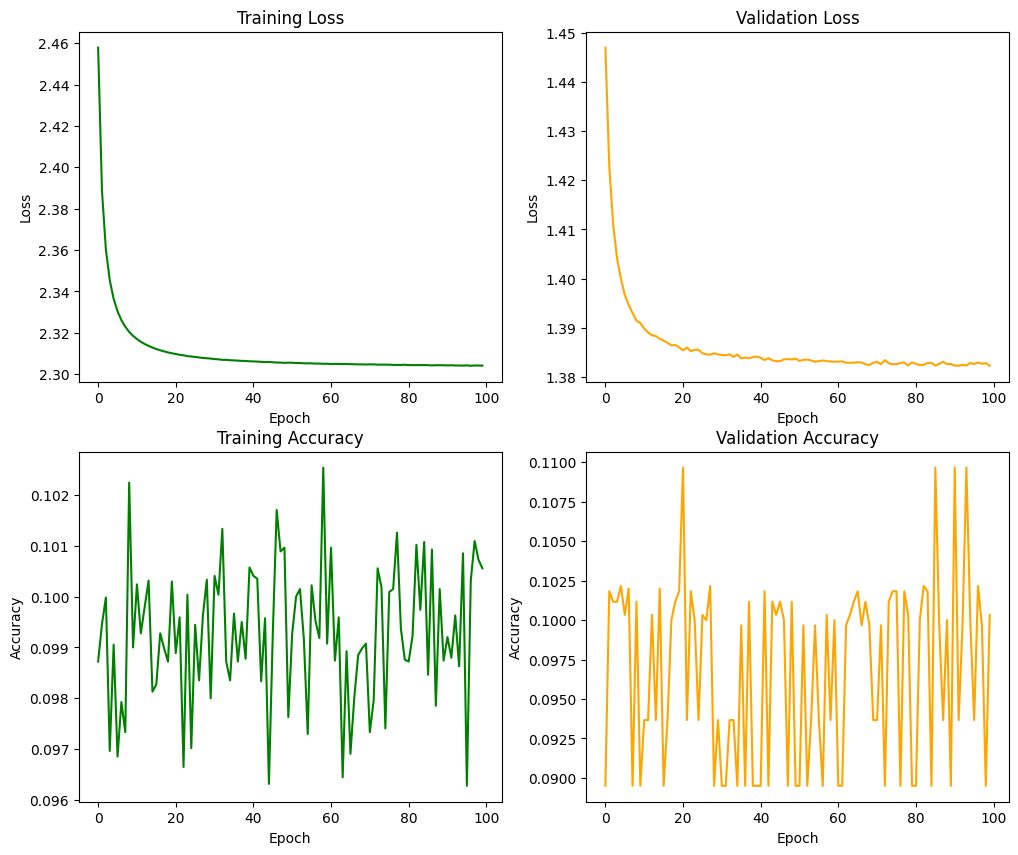

In [31]:
plot_loss_acc(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

## **4. Evaluation**


In [32]:
def evaluate(model, test_loader):
    val_target = []
    val_predict = []

    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)

            val_predict.append(outputs.cpu())
            val_target.append(y_val.cpu())

        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = (torch.argmax(val_predict, 1) == val_target).sum().item() / len(val_target)

        print('Evaluation on val set:')
        print(f'Accuracy: {val_acc}')
    return val_acc

In [33]:
evaluate(model, val_loader)

Evaluation on val set:
Accuracy: 0.10033333333333333


0.10033333333333333

# Improvement

## 1. Weight Increasing

In [34]:
class MLP_STD1(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_STD1, self).__init__()
        # 7 layers
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, hidden_dims)
        self.fc4 = nn.Linear(hidden_dims, hidden_dims)
        self.fc5 = nn.Linear(hidden_dims, hidden_dims)
        self.fc6 = nn.Linear(hidden_dims, hidden_dims)
        self.fc7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.act_func = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=1.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.act_func(x)
        x = self.fc2(x)
        x = self.act_func(x)
        x = self.fc3(x)
        x = self.act_func(x)
        x = self.fc4(x)
        x = self.act_func(x)
        x = self.fc5(x)
        x = self.act_func(x)
        x = self.fc6(x)
        x = self.act_func(x)
        x = self.fc7(x)
        x = self.act_func(x)
        x = self.output(x)
        return x


In [35]:
class MLP_STD10(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_STD10, self).__init__()
        # 7 layers
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, hidden_dims)
        self.fc4 = nn.Linear(hidden_dims, hidden_dims)
        self.fc5 = nn.Linear(hidden_dims, hidden_dims)
        self.fc6 = nn.Linear(hidden_dims, hidden_dims)
        self.fc7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.act_func = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=10.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.act_func(x)
        x = self.fc2(x)
        x = self.act_func(x)
        x = self.fc3(x)
        x = self.act_func(x)
        x = self.fc4(x)
        x = self.act_func(x)
        x = self.fc5(x)
        x = self.act_func(x)
        x = self.fc6(x)
        x = self.act_func(x)
        x = self.fc7(x)
        x = self.act_func(x)
        x = self.output(x)
        return x

In [36]:
input_dims = 28*28
hidden_dims = 128
output_dims = 100
lr = 1e-2
batch_size = 512
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader, val_loader, test_loader = get_data(batch_size)
model_std1 = MLP_STD1(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
model_std10 = MLP_STD10(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion_std1 = nn.CrossEntropyLoss()
optimizer_std1 = optim.SGD(model_std1.parameters(), lr=lr)
criterion_std10 = nn.CrossEntropyLoss()
optimizer_std10 = optim.SGD(model_std10.parameters(), lr=lr)


Train size: 54000
Validation size: 6000
Test size: 10000


In [37]:
model_std1, (train_loss_std1_lst, train_acc_std1_lst, val_loss_std1_lst, val_acc_std1_lst) = train(model_std1, train_loader, val_loader, criterion_std1, optimizer_std1, epochs, device)
model_std10, (train_loss_std10_lst, train_acc_std10_lst, val_loss_std10_lst, val_acc_std10_lst) = train(model_std10, train_loader, val_loader, criterion_std10, optimizer_std10, epochs, device)

EPOCH 1/100, Train_Loss: 7.0723, Train_Acc: 0.0944, Validation Loss: 1.8042, Val_Acc: 0.2088
EPOCH 2/100, Train_Loss: 2.3407, Train_Acc: 0.2741, Validation Loss: 1.1633, Val_Acc: 0.3552
EPOCH 3/100, Train_Loss: 1.7953, Train_Acc: 0.3926, Validation Loss: 0.9965, Val_Acc: 0.4415
EPOCH 4/100, Train_Loss: 1.5833, Train_Acc: 0.4563, Validation Loss: 0.9023, Val_Acc: 0.4822
EPOCH 5/100, Train_Loss: 1.4582, Train_Acc: 0.4913, Validation Loss: 0.8431, Val_Acc: 0.5165
EPOCH 6/100, Train_Loss: 1.3764, Train_Acc: 0.5158, Validation Loss: 0.8015, Val_Acc: 0.5370
EPOCH 7/100, Train_Loss: 1.3160, Train_Acc: 0.5345, Validation Loss: 0.7698, Val_Acc: 0.5530
EPOCH 8/100, Train_Loss: 1.2686, Train_Acc: 0.5496, Validation Loss: 0.7448, Val_Acc: 0.5617
EPOCH 9/100, Train_Loss: 1.2290, Train_Acc: 0.5619, Validation Loss: 0.7231, Val_Acc: 0.5767
EPOCH 10/100, Train_Loss: 1.1949, Train_Acc: 0.5727, Validation Loss: 0.7051, Val_Acc: 0.5868
EPOCH 11/100, Train_Loss: 1.1659, Train_Acc: 0.5832, Validation Loss:

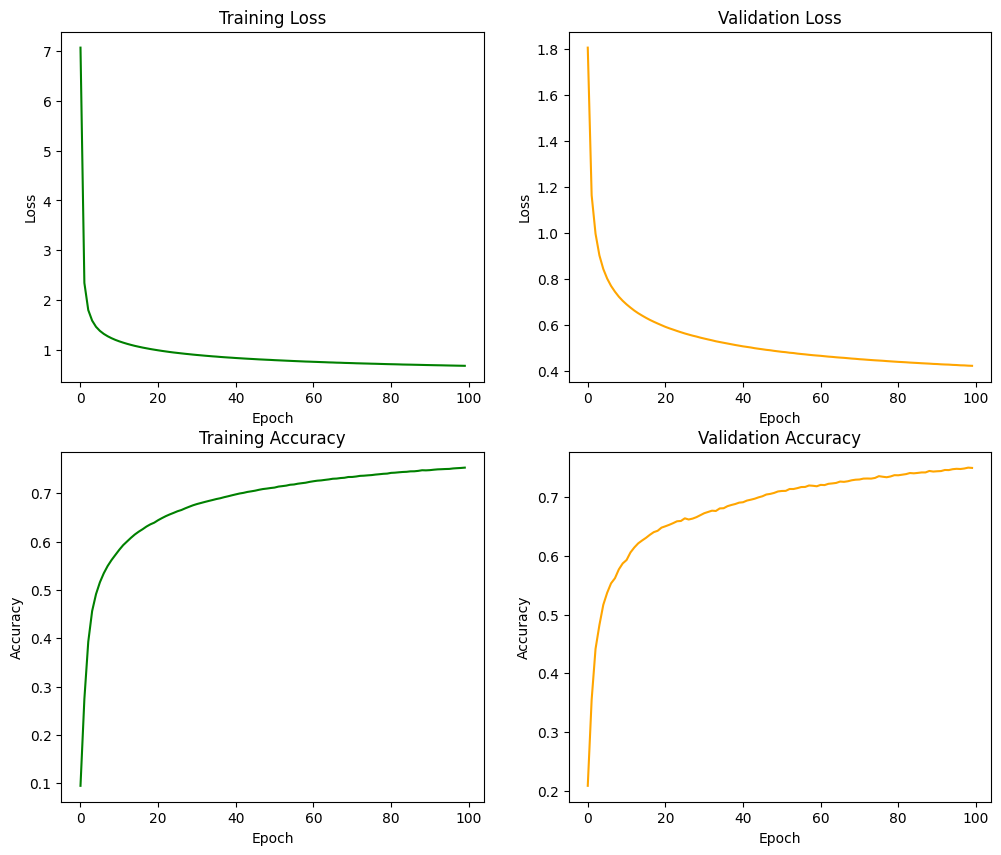

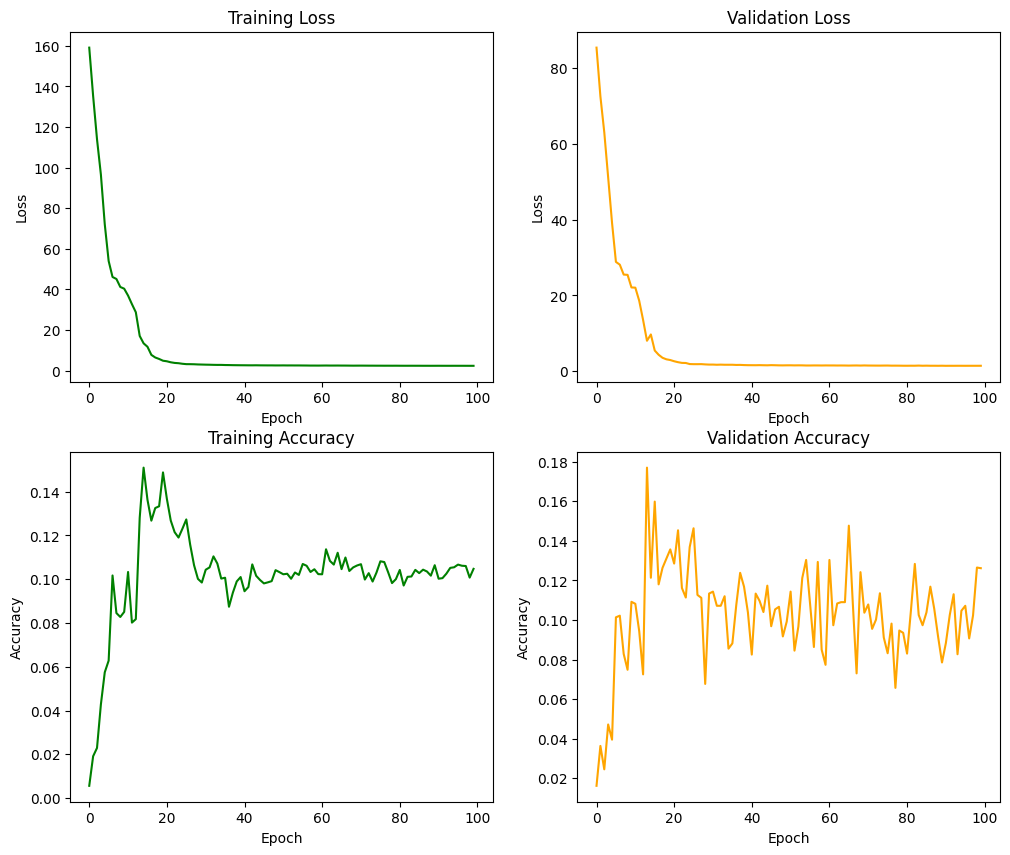

In [38]:
plot_loss_acc(train_loss_std1_lst, val_loss_std1_lst, train_acc_std1_lst, val_acc_std1_lst)
plot_loss_acc(train_loss_std10_lst, val_loss_std10_lst, train_acc_std10_lst, val_acc_std10_lst)

In [39]:
print('Evaluation on val set:')
print('STD1', evaluate(model_std1, val_loader))
print('STD10', evaluate(model_std10, val_loader))

Evaluation on val set:
Evaluation on val set:
Accuracy: 0.7491666666666666
STD1 0.7491666666666666
Evaluation on val set:
Accuracy: 0.12616666666666668
STD10 0.12616666666666668


## 2. Better Activation

In [50]:
class MLP_RELU(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_RELU, self).__init__()
        # 7 layers
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, hidden_dims)
        self.fc4 = nn.Linear(hidden_dims, hidden_dims)
        self.fc5 = nn.Linear(hidden_dims, hidden_dims)
        self.fc6 = nn.Linear(hidden_dims, hidden_dims)
        self.fc7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.act_func = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.act_func(x)
        x = self.fc2(x)
        x = self.act_func(x)
        x = self.fc3(x)
        x = self.act_func(x)
        x = self.fc4(x)
        x = self.act_func(x)
        x = self.fc5(x)
        x = self.act_func(x)
        x = self.fc6(x)
        x = self.act_func(x)
        x = self.fc7(x)
        x = self.act_func(x)
        x = self.output(x)
        return x

In [51]:
input_dims = 28*28
hidden_dims = 128
output_dims = 100
lr = 1e-2
batch_size = 512
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader, val_loader, test_loader = get_data(batch_size)
model_relu = MLP_RELU(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)


criterion_relu = nn.CrossEntropyLoss()
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

Train size: 54000
Validation size: 6000
Test size: 10000


In [52]:
model_relu, (train_loss_relu_lst, train_acc_relu_lst, val_loss_relu_lst, val_acc_relu_lst) = train(model_relu, train_loader, val_loader, criterion_relu, optimizer_relu, epochs, device)

EPOCH 1/100, Train_Loss: 4.5499, Train_Acc: 0.1041, Validation Loss: 2.6959, Val_Acc: 0.0975
EPOCH 2/100, Train_Loss: 4.4357, Train_Acc: 0.1026, Validation Loss: 2.6253, Val_Acc: 0.0975
EPOCH 3/100, Train_Loss: 4.3108, Train_Acc: 0.1003, Validation Loss: 2.5446, Val_Acc: 0.0975
EPOCH 4/100, Train_Loss: 4.1596, Train_Acc: 0.1003, Validation Loss: 2.4410, Val_Acc: 0.0975
EPOCH 5/100, Train_Loss: 3.9514, Train_Acc: 0.1003, Validation Loss: 2.2879, Val_Acc: 0.0975
EPOCH 6/100, Train_Loss: 3.6120, Train_Acc: 0.1003, Validation Loss: 2.0120, Val_Acc: 0.0975
EPOCH 7/100, Train_Loss: 2.8982, Train_Acc: 0.1075, Validation Loss: 1.4492, Val_Acc: 0.1040
EPOCH 8/100, Train_Loss: 2.3267, Train_Acc: 0.0989, Validation Loss: 1.3747, Val_Acc: 0.0997
EPOCH 9/100, Train_Loss: 2.2815, Train_Acc: 0.1011, Validation Loss: 1.3629, Val_Acc: 0.0983
EPOCH 10/100, Train_Loss: 2.2638, Train_Acc: 0.1004, Validation Loss: 1.3527, Val_Acc: 0.1030
EPOCH 11/100, Train_Loss: 2.2470, Train_Acc: 0.1058, Validation Loss:

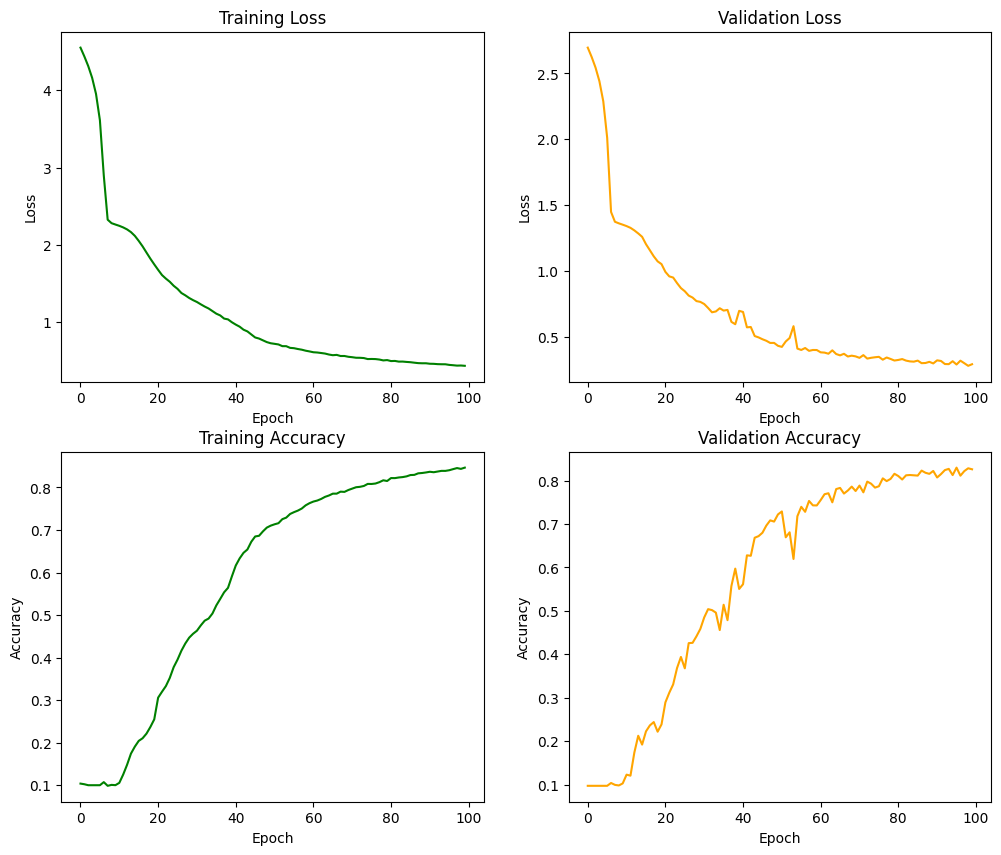

In [53]:
plot_loss_acc(train_loss_relu_lst, val_loss_relu_lst, train_acc_relu_lst, val_acc_relu_lst)

In [54]:
print('Evaluation on val set:')
print('RELU', evaluate(model_relu, val_loader))

Evaluation on val set:
Evaluation on val set:
Accuracy: 0.8258333333333333
RELU 0.8258333333333333


## 3. Better Optimizer

In [55]:
input_dims = 28*28
hidden_dims = 128
output_dims = 100
lr = 1e-2
batch_size = 512
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader, val_loader, test_loader = get_data(batch_size)
model_relu = MLP_RELU(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)


criterion_relu = nn.CrossEntropyLoss()
optimizer_relu_adam = optim.Adam(model_relu.parameters(), lr=lr)

Train size: 54000
Validation size: 6000
Test size: 10000


In [56]:
model_relu, (train_loss_relu_lst, train_acc_relu_lst, val_loss_relu_lst, val_acc_relu_lst) = train(model_relu, train_loader, val_loader, criterion_relu, optimizer_relu_adam, epochs, device)

EPOCH 1/100, Train_Loss: 1.5456, Train_Acc: 0.3881, Validation Loss: 0.4784, Val_Acc: 0.7153
EPOCH 2/100, Train_Loss: 0.6425, Train_Acc: 0.7610, Validation Loss: 0.3097, Val_Acc: 0.8090
EPOCH 3/100, Train_Loss: 0.4790, Train_Acc: 0.8260, Validation Loss: 0.2876, Val_Acc: 0.8287
EPOCH 4/100, Train_Loss: 0.4219, Train_Acc: 0.8493, Validation Loss: 0.2382, Val_Acc: 0.8608
EPOCH 5/100, Train_Loss: 0.3954, Train_Acc: 0.8596, Validation Loss: 0.2465, Val_Acc: 0.8613
EPOCH 6/100, Train_Loss: 0.3750, Train_Acc: 0.8660, Validation Loss: 0.2316, Val_Acc: 0.8595
EPOCH 7/100, Train_Loss: 0.3577, Train_Acc: 0.8714, Validation Loss: 0.2439, Val_Acc: 0.8640
EPOCH 8/100, Train_Loss: 0.3457, Train_Acc: 0.8755, Validation Loss: 0.2314, Val_Acc: 0.8733
EPOCH 9/100, Train_Loss: 0.3326, Train_Acc: 0.8803, Validation Loss: 0.2115, Val_Acc: 0.8770
EPOCH 10/100, Train_Loss: 0.3187, Train_Acc: 0.8837, Validation Loss: 0.2259, Val_Acc: 0.8730
EPOCH 11/100, Train_Loss: 0.3217, Train_Acc: 0.8826, Validation Loss:

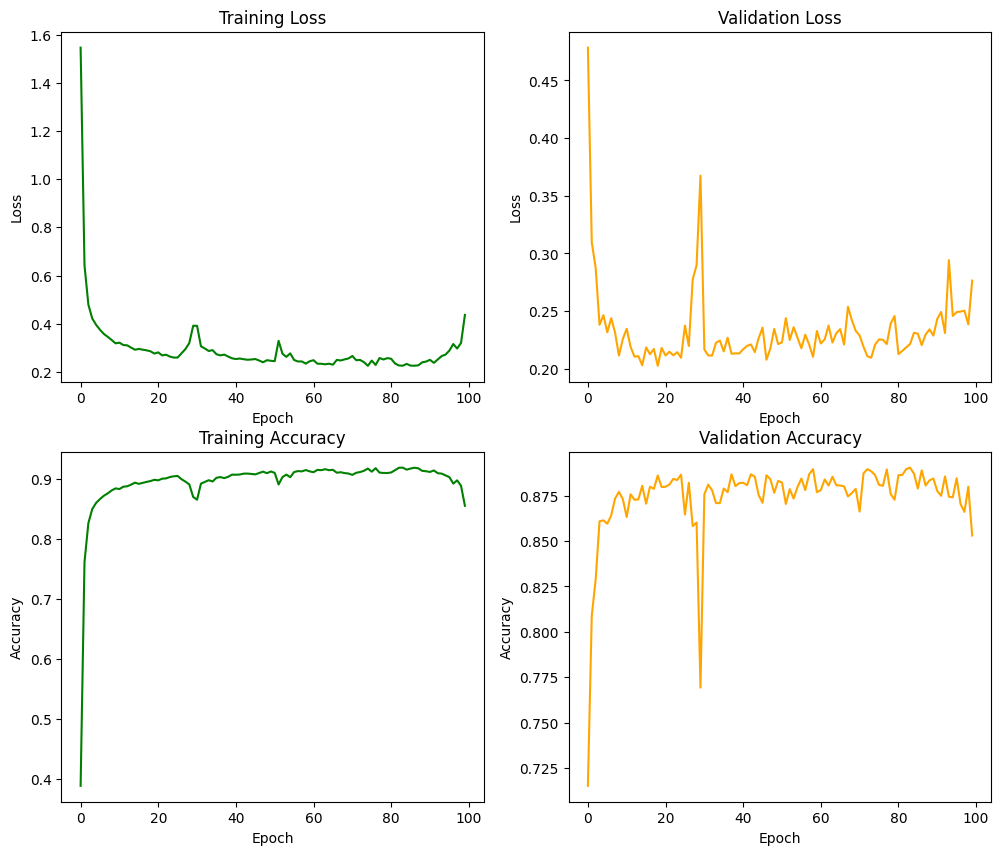

In [57]:
plot_loss_acc(train_loss_relu_lst, val_loss_relu_lst, train_acc_relu_lst, val_acc_relu_lst)

In [58]:
print('Evaluation on val set:')
print('RELU + Adam', evaluate(model_relu, val_loader))

Evaluation on val set:
Evaluation on val set:
Accuracy: 0.853
RELU + Adam 0.853


## 4. Normalize Inside Network

In [59]:
class MLP_NORM(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_NORM, self).__init__()
        # 7 layers
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, hidden_dims)
        self.fc4 = nn.Linear(hidden_dims, hidden_dims)
        self.fc5 = nn.Linear(hidden_dims, hidden_dims)
        self.fc6 = nn.Linear(hidden_dims, hidden_dims)
        self.fc7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.act_func = nn.ReLU()
        self.bn = nn.BatchNorm1d(hidden_dims)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc2(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc3(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc4(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc5(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc6(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc7(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.output(x)
        return x

In [66]:
class CUSTOMIZED_NORM(nn.Module):
    def __init__(self):
        super(CUSTOMIZED_NORM, self).__init__()

    def forward(self, x):
        mean = x.mean(dim=0)
        std = x.std(dim=0)
        return (x - mean) / std


class MLP_CUSTOMIZED_NORM(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_CUSTOMIZED_NORM, self).__init__()
        # 7 layers
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, hidden_dims)
        self.fc4 = nn.Linear(hidden_dims, hidden_dims)
        self.fc5 = nn.Linear(hidden_dims, hidden_dims)
        self.fc6 = nn.Linear(hidden_dims, hidden_dims)
        self.fc7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.act_func = nn.ReLU()
        self.bn = CUSTOMIZED_NORM()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc2(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc3(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc4(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc5(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc6(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc7(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.output(x)
        return x

In [69]:
input_dims = 28*28
hidden_dims = 128
output_dims = 100
lr = 1e-2
batch_size = 512
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader, val_loader, test_loader = get_data(batch_size)
model_customized_norm = MLP_CUSTOMIZED_NORM(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
model_norm = MLP_NORM(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion_customized_norm = nn.CrossEntropyLoss()
optimizer_customized_norm = optim.Adam(model_customized_norm.parameters(), lr=lr)
criterion_norm = nn.CrossEntropyLoss()
optimizer_norm = optim.Adam(model_norm.parameters(), lr=lr)

Train size: 54000
Validation size: 6000
Test size: 10000


In [70]:
model_customized_norm, (train_loss_customized_norm_lst, train_acc_customized_norm_lst, val_loss_customized_norm_lst, val_acc_customized_norm_lst) = train(model_customized_norm, train_loader, val_loader, criterion_customized_norm, optimizer_customized_norm, epochs, device)
model_norm, (train_loss_norm_lst, train_acc_norm_lst, val_loss_norm_lst, val_acc_norm_lst) = train(model_norm, train_loader, val_loader, criterion_norm, optimizer_norm, epochs, device)

EPOCH 1/100, Train_Loss: 0.6045, Train_Acc: 0.7999, Validation Loss: 0.2573, Val_Acc: 0.8403
EPOCH 2/100, Train_Loss: 0.3769, Train_Acc: 0.8634, Validation Loss: 0.2294, Val_Acc: 0.8595
EPOCH 3/100, Train_Loss: 0.3436, Train_Acc: 0.8746, Validation Loss: 0.2121, Val_Acc: 0.8713
EPOCH 4/100, Train_Loss: 0.3169, Train_Acc: 0.8833, Validation Loss: 0.2062, Val_Acc: 0.8780
EPOCH 5/100, Train_Loss: 0.2923, Train_Acc: 0.8930, Validation Loss: 0.1937, Val_Acc: 0.8845
EPOCH 6/100, Train_Loss: 0.2834, Train_Acc: 0.8956, Validation Loss: 0.1981, Val_Acc: 0.8797
EPOCH 7/100, Train_Loss: 0.2656, Train_Acc: 0.9023, Validation Loss: 0.1866, Val_Acc: 0.8888
EPOCH 8/100, Train_Loss: 0.2427, Train_Acc: 0.9098, Validation Loss: 0.2041, Val_Acc: 0.8812
EPOCH 9/100, Train_Loss: 0.2422, Train_Acc: 0.9096, Validation Loss: 0.2011, Val_Acc: 0.8820
EPOCH 10/100, Train_Loss: 0.2264, Train_Acc: 0.9161, Validation Loss: 0.1996, Val_Acc: 0.8850
EPOCH 11/100, Train_Loss: 0.2223, Train_Acc: 0.9172, Validation Loss:

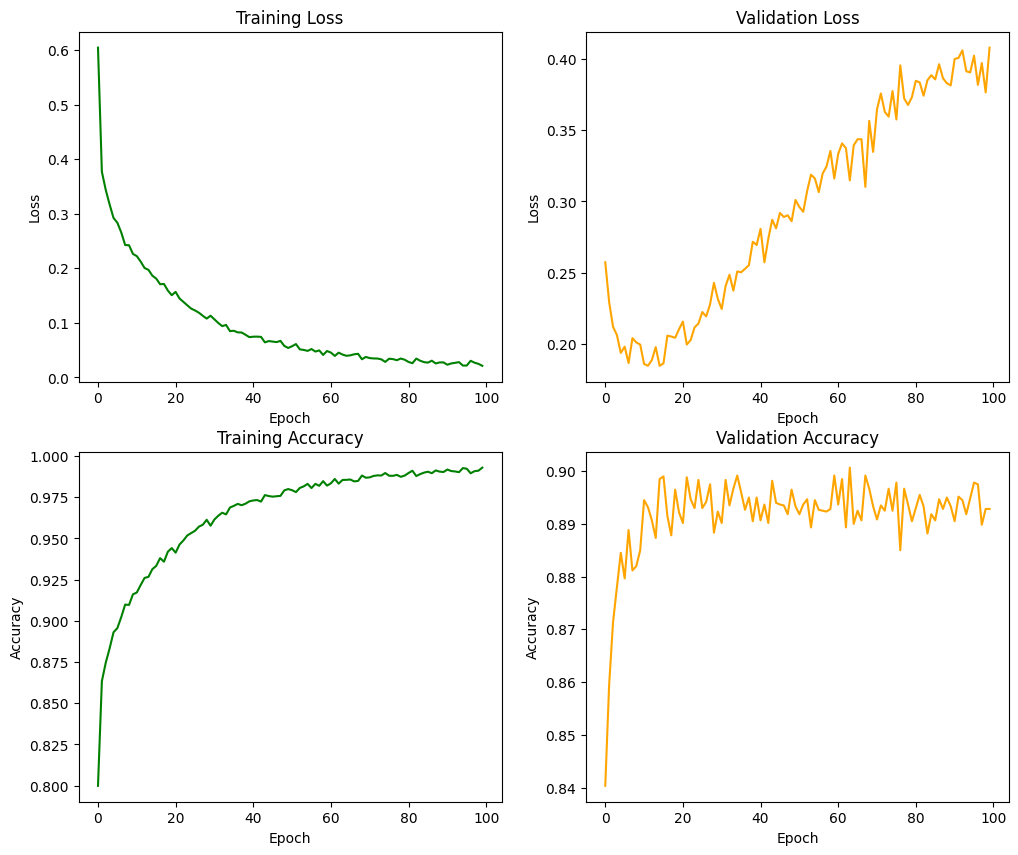

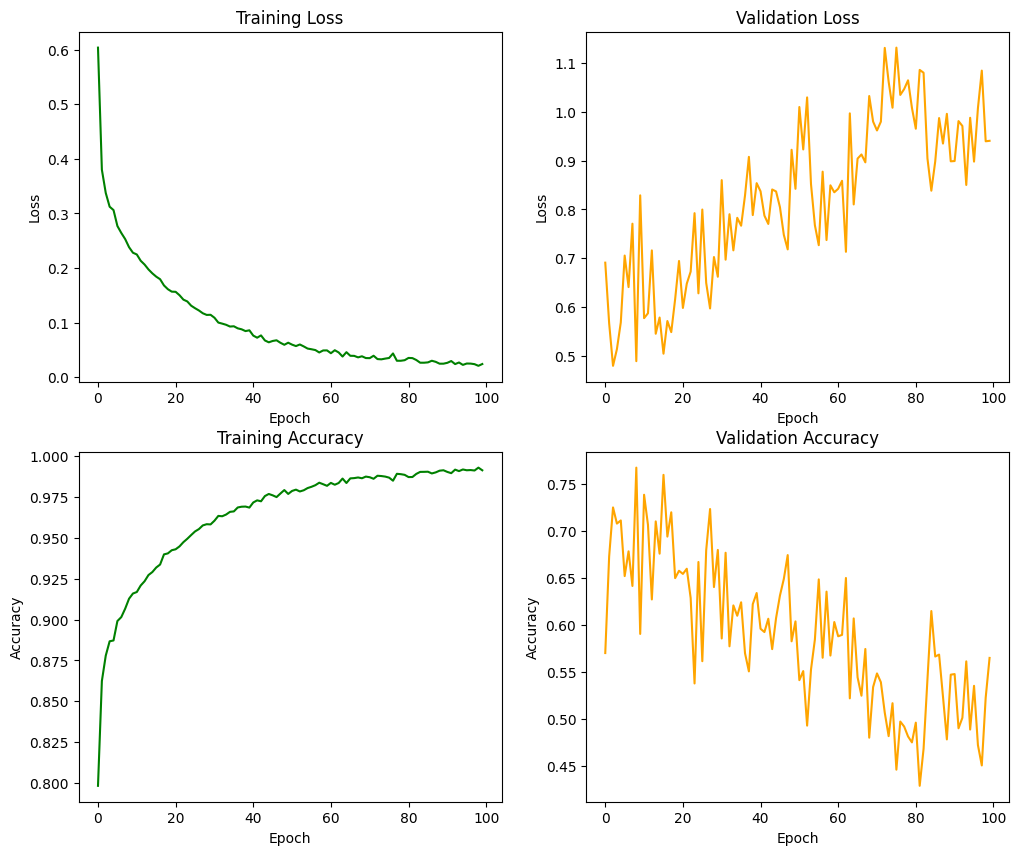

In [71]:
plot_loss_acc(train_loss_customized_norm_lst, val_loss_customized_norm_lst, train_acc_customized_norm_lst, val_acc_customized_norm_lst)
plot_loss_acc(train_loss_norm_lst, val_loss_norm_lst, train_acc_norm_lst, val_acc_norm_lst)

In [72]:
print('Evaluation on val set:')
print('CUSTOMIZED_NORM', evaluate(model_customized_norm, val_loader))
print('NORM', evaluate(model_norm, val_loader))

Evaluation on val set:
Evaluation on val set:
Accuracy: 0.8928333333333334
CUSTOMIZED_NORM 0.8928333333333334
Evaluation on val set:
Accuracy: 0.5648333333333333
NORM 0.5648333333333333


## 5. Skip Connection

In [76]:
class MLP_SKIP_CONNECTION(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_SKIP_CONNECTION, self).__init__()
        # 7 layers
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims)
        self.fc3 = nn.Linear(hidden_dims, hidden_dims)
        self.fc4 = nn.Linear(hidden_dims, hidden_dims)
        self.fc5 = nn.Linear(hidden_dims, hidden_dims)
        self.fc6 = nn.Linear(hidden_dims, hidden_dims)
        self.fc7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.act_func = nn.ReLU()
        self.bn = CUSTOMIZED_NORM()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.act_func(x)
        skip = x

        x = self.fc2(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc3(x)
        x = self.bn(x)
        x = self.act_func(x)
        x = x + skip


        x = self.fc4(x)
        x = self.bn(x)
        x = self.act_func(x)
        skip = x

        x = self.fc5(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc6(x)
        x = self.bn(x)
        x = self.act_func(x)

        x = self.fc7(x)
        x = self.bn(x)
        x = self.act_func(x)
        x = x + skip

        x = self.output(x)
        return x

In [77]:
input_dims = 28*28
hidden_dims = 128
output_dims = 100
lr = 1e-2
batch_size = 512
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader, val_loader, test_loader = get_data(batch_size)

model_skip_connection = MLP_SKIP_CONNECTION(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion_skip_connection = nn.CrossEntropyLoss()
optimizer_skip_connection = optim.Adam(model_skip_connection.parameters(), lr=lr)

Train size: 54000
Validation size: 6000
Test size: 10000


In [78]:
model_skip_connection, (train_loss_skip_connection_lst, train_acc_skip_connection_lst, val_loss_skip_connection_lst, val_acc_skip_connection_lst) = train(model_skip_connection, train_loader, val_loader, criterion_skip_connection, optimizer_skip_connection, epochs, device)

EPOCH 1/100, Train_Loss: 0.5416, Train_Acc: 0.8137, Validation Loss: 0.2468, Val_Acc: 0.8515
EPOCH 2/100, Train_Loss: 0.3597, Train_Acc: 0.8694, Validation Loss: 0.2301, Val_Acc: 0.8602
EPOCH 3/100, Train_Loss: 0.3179, Train_Acc: 0.8841, Validation Loss: 0.2095, Val_Acc: 0.8708
EPOCH 4/100, Train_Loss: 0.2907, Train_Acc: 0.8926, Validation Loss: 0.2221, Val_Acc: 0.8692
EPOCH 5/100, Train_Loss: 0.2756, Train_Acc: 0.8973, Validation Loss: 0.2068, Val_Acc: 0.8750
EPOCH 6/100, Train_Loss: 0.2581, Train_Acc: 0.9034, Validation Loss: 0.2139, Val_Acc: 0.8723
EPOCH 7/100, Train_Loss: 0.2458, Train_Acc: 0.9091, Validation Loss: 0.2135, Val_Acc: 0.8730
EPOCH 8/100, Train_Loss: 0.2303, Train_Acc: 0.9145, Validation Loss: 0.1951, Val_Acc: 0.8817
EPOCH 9/100, Train_Loss: 0.2142, Train_Acc: 0.9197, Validation Loss: 0.2059, Val_Acc: 0.8793
EPOCH 10/100, Train_Loss: 0.2053, Train_Acc: 0.9235, Validation Loss: 0.2057, Val_Acc: 0.8833
EPOCH 11/100, Train_Loss: 0.1998, Train_Acc: 0.9250, Validation Loss:

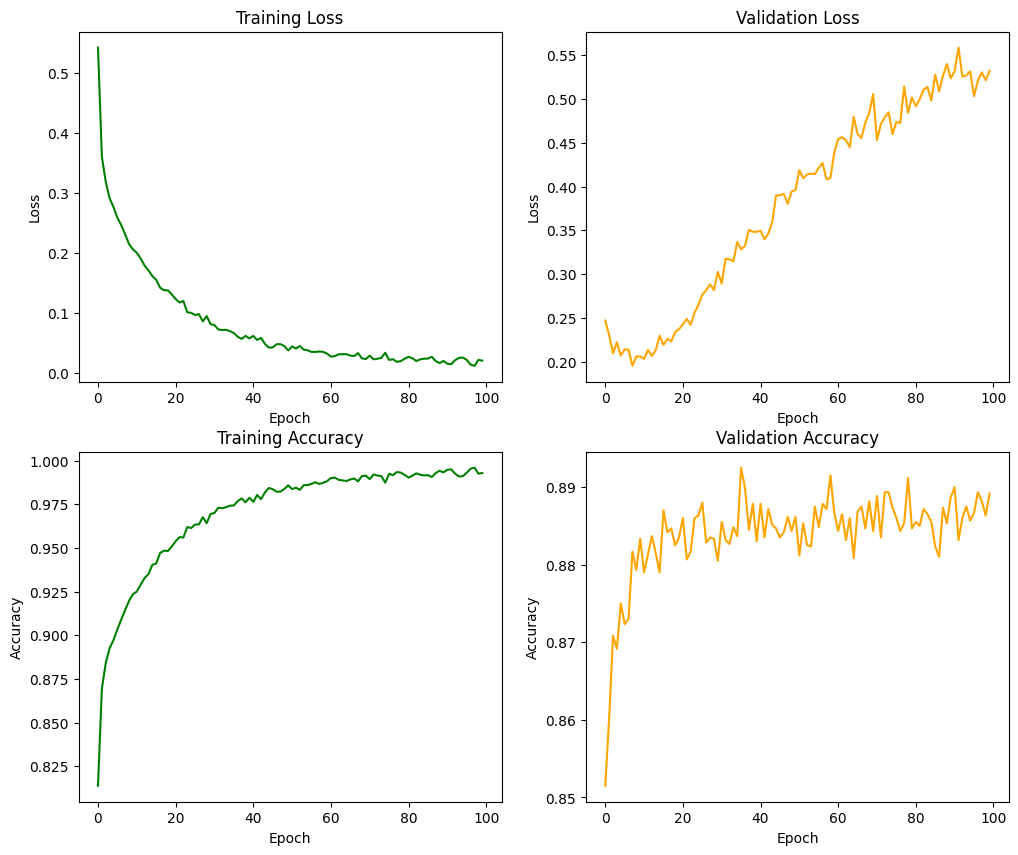

In [79]:
plot_loss_acc(train_loss_skip_connection_lst, val_loss_skip_connection_lst, train_acc_skip_connection_lst, val_acc_skip_connection_lst)

In [80]:
print('Evaluation on val set:')
print('SKIP_CONNECTION', evaluate(model_skip_connection, val_loader))

Evaluation on val set:
Evaluation on val set:
Accuracy: 0.8891666666666667
SKIP_CONNECTION 0.8891666666666667
